## Learning session

In [1]:
# L_level_change
import pandas as pd
import numpy as np

# Define a function to keep the original format as a string
def keep_original_format(x):
    return str(x)
# Load the Excel file and use the converter for the "Duration (min:sec)" column
file_path = 'student8/s8.xlsx'
df = pd.read_excel(file_path, converters={'outcome': keep_original_format})

In [2]:
df['start_time'] = df['start_time'].ffill()

In [3]:
import pandas as pd
import re

def convert_to_seconds(duration):
    # Split the duration into parts
    parts = duration.split(':')
    
    if len(parts) == 3:
        # Handle HH:MM:SS format
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2])
        return hours * 3600 + minutes * 60 + seconds
    
    elif len(parts) == 2:
        # Handle MM:SS format
        minutes = int(parts[0])
        seconds = int(parts[1])
        return minutes * 60 + seconds
    
    return 0  # Return 0 for unexpected formats

# Ensure 'Duration (min:sec)' is treated as a string and then apply the function
df['Duration (min:sec)'] = df['Duration (min:sec)'].astype(str)
df['Duration (seconds)'] = df['Duration (min:sec)'].apply(lambda x: convert_to_seconds(x) if pd.notna(x) else 0)

In [3]:
# 1. Create the group column
non_nan_mask = df['session'].notna()
df['group'] = non_nan_mask.cumsum()

# 2. Fill 'Start Time', 'End Time', and 'Session' for each group
df[['start_time', 'end_time', 'session']] = (
    df
    .groupby('group')[['start_time', 'end_time', 'session']]
    .transform(lambda col: col.ffill())
)

skill ='G7 8.5'#G9 12.4

# 3. Filter and display rows where 'skill_head' == 'G3 1.5'
filtered_df = df.loc[df['skill'] == skill]

In [4]:
df.head()

,start_time,end_time,Duration (min:sec),Score,At LC,Points,grade,session,skill,skill_level_change,...,cum_wrong_day,cum_hints_day,cum_same_skill_day,same_skill_wrong,session_id,PI_score,PI_score_change,deltaPI_score_future1,deltaPI_score_past1,group
0,2020-08-09 14:09:53,2020-08-09 14:11:24,01:31,67.71(0.80),NaN,--,4,PROFICIENCY,G4 1.1,23.0,...,0,0,1,0,1,67.71,0.8,0.32,0.8,1
1,2020-08-09 14:09:53,NaT,NaN,NaN,NaN,NaN,4,PROFICIENCY,G4 1.2,23.0,...,0,0,1,0,1,NaN,NaN,NaN,NaN,2
2,2020-08-09 14:09:53,NaT,NaN,NaN,NaN,NaN,4,PROFICIENCY,G4 1.3,23.0,...,0,0,1,0,1,NaN,NaN,NaN,NaN,3
3,2020-08-09 14:09:53,NaT,NaN,NaN,NaN,NaN,4,PROFICIENCY,G4 1.4,23.0,...,0,0,1,0,1,NaN,NaN,NaN,NaN,4
4,2020-08-09 14:09:53,NaT,NaN,NaN,NaN,NaN,4,PROFICIENCY,G4 1.5,23.0,...,0,0,1,0,1,NaN,NaN,NaN,NaN,5


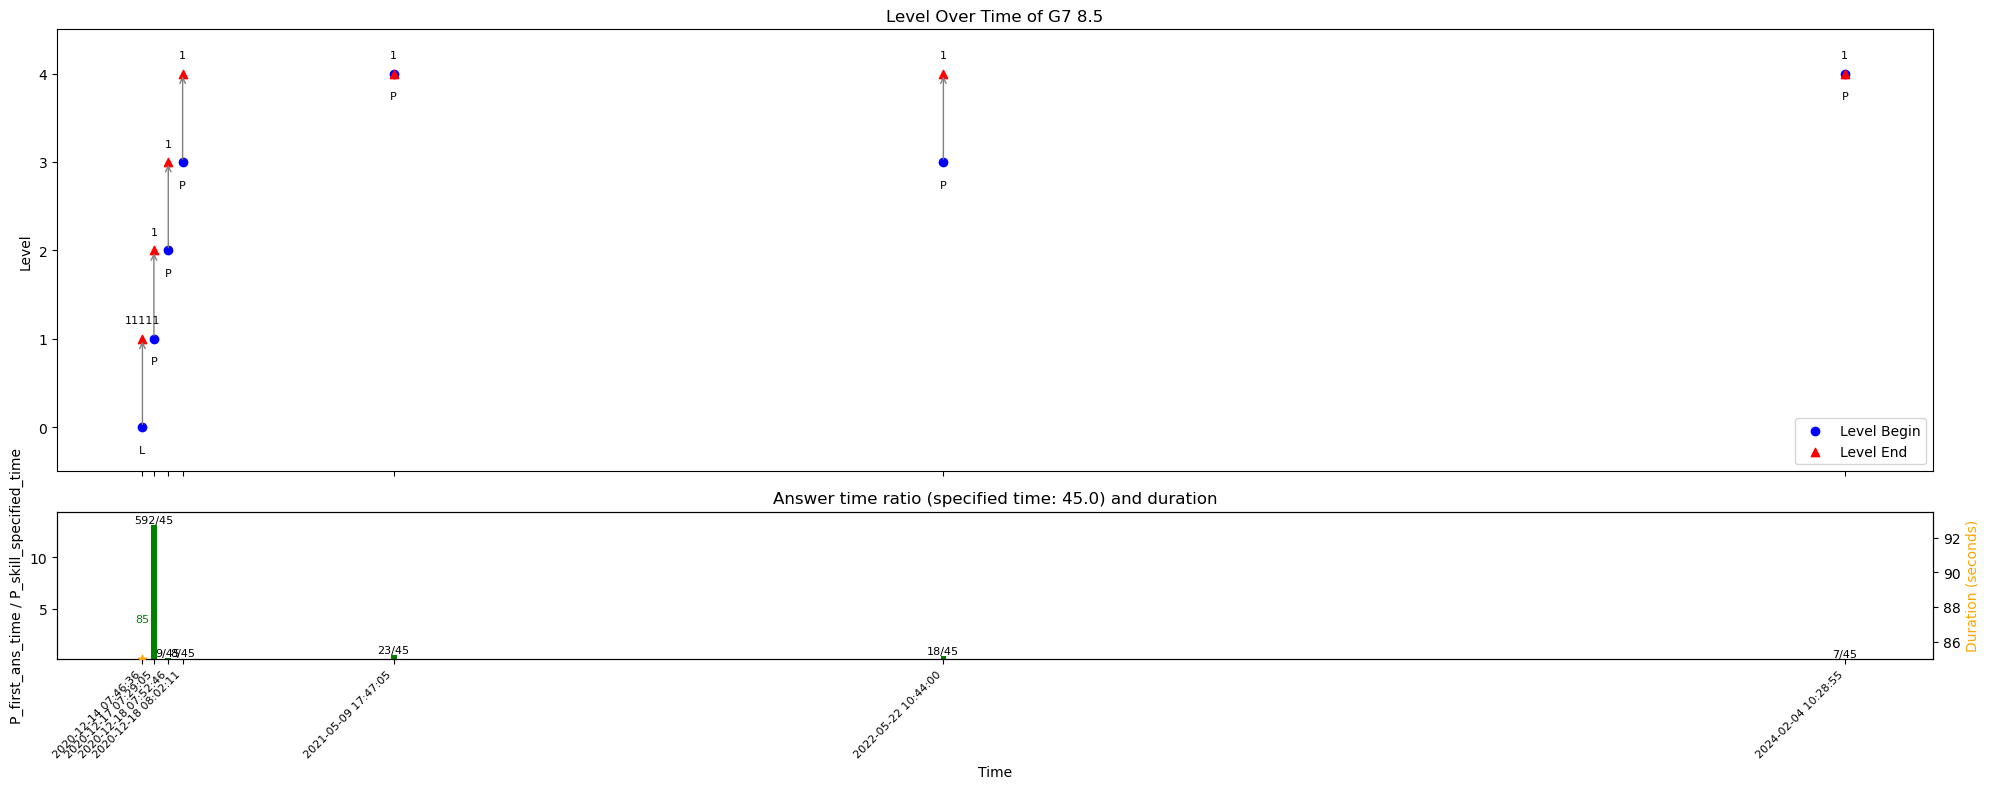

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Work on a copy of the DataFrame
filtered_df = filtered_df.copy()

# Convert time columns to string and to datetime for gap calculations and duration computation
filtered_df['start_time'] = filtered_df['start_time'].astype(str)
filtered_df['end_time']   = filtered_df['end_time'].astype(str)
filtered_df['start_time_dt'] = pd.to_datetime(filtered_df['start_time'])
filtered_df['end_time_dt'] = pd.to_datetime(filtered_df['end_time'])

# Build new x_positions by inserting gaps based on day differences
new_x_positions = []
current_x = 0
new_x_positions.append(current_x)
for i in range(1, len(filtered_df)):
    prev_time = filtered_df['start_time_dt'].iloc[i-1]
    curr_time = filtered_df['start_time_dt'].iloc[i]
    diff_days = (curr_time.date() - prev_time.date()).days
    if diff_days <= 1:
        blanks = 1
    else:
        blanks = diff_days / 5  # adjust as needed
    current_x += 1 + blanks
    new_x_positions.append(current_x)

# Ensure P_first_ans_time and P_P_P_P_P_P_P_P_P_skill_specified_time are numeric
filtered_df['P_first_ans_time'] = pd.to_numeric(filtered_df['P_first_ans_time'], errors='coerce')
filtered_df['P_skill_specified_time'] = pd.to_numeric(filtered_df['P_skill_specified_time'], errors='coerce')

# Compute the ratio for the bar chart (if available)
filtered_df['ratio'] = filtered_df['P_first_ans_time'] / filtered_df['P_skill_specified_time']

# Compute Duration in seconds (difference between end_time and start_time)
duration_seconds = (filtered_df['end_time_dt'] - filtered_df['start_time_dt']).dt.total_seconds()
filtered_df['Duration (seconds)'] = duration_seconds

# Create a figure with two subplots sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8),
                               sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# ----- Top subplot: Level Chart -----
ax1.scatter(new_x_positions, filtered_df['level_begin'], label='Level Begin', color='blue')
ax1.scatter(new_x_positions, filtered_df['level_end'], label='Level End', marker='^', color='red')

# Draw an arrow for rows where level_begin and level_end differ
for x, lvl_begin, lvl_end in zip(new_x_positions,
                                 filtered_df['level_begin'],
                                 filtered_df['level_end']):
    if lvl_begin != lvl_end:
        ax1.annotate('', xy=(x, lvl_end), xytext=(x, lvl_begin),
                     arrowprops=dict(arrowstyle="->", color='gray'))

# Add session letter and outcome below the marker that has the lower level value
offset = 0.2         # vertical offset for session letter
outcome_offset = 0.15 # additional offset for outcome text
for x, lvl_begin, lvl_end, session, outcome in zip(new_x_positions,
                                                   filtered_df['level_begin'],
                                                   filtered_df['level_end'],
                                                   filtered_df['session'],
                                                   filtered_df['outcome']):
    if session == "LEARNING":
        letter = "L"
    elif session == "PROFICIENCY":
        letter = "P"
    elif session == "AFFICIENCY":
        letter = "A"
    else:
        letter = None

    if letter is not None:
        lower_val = min(lvl_begin, lvl_end)
        higher_val=max(lvl_begin, lvl_end)
        # Draw session letter below the lower marker
        ax1.text(x, lower_val - offset, letter, ha='center', va='top', fontsize=8, color='black')
        # Draw outcome above the higher marker
        ax1.text(x, higher_val + outcome_offset, outcome, ha='center', va='bottom', fontsize=8, color='black')

ax1.set_xticks(new_x_positions)
ax1.set_xticklabels(filtered_df['start_time'], rotation=45, ha='right', fontsize=8)
ax1.set_ylabel('Level')
ax1.set_title(f'Level Over Time of {skill}')
ax1.legend()

min_level = min(filtered_df['level_begin'].min(), filtered_df['level_end'].min())
max_level = max(filtered_df['level_begin'].max(), filtered_df['level_end'].max())
ax1.set_ylim(min_level - 0.5, max_level + 0.5)

# ----- Bottom subplot: Bar Chart for P_first_ans_time/skill_specified_time and Scatter for Duration -----
# Separate data for bar chart (valid ratio) and scatter (duration when ratio is NaN)
x_bar = []
ratio_values = []
fat_values = []  # P_first_ans_time values for annotation
sst_values = []  # skill_specified_time values for annotation
x_scatter = []
duration_values = []
for x, ratio_val, fat, sst, dur in zip(new_x_positions,
                                         filtered_df['ratio'],
                                         filtered_df['P_first_ans_time'],
                                         filtered_df['P_skill_specified_time'],
                                         filtered_df['Duration (seconds)']):
    if pd.isna(ratio_val):
        x_scatter.append(x)
        duration_values.append(dur)
    else:
        x_bar.append(x)
        ratio_values.append(ratio_val)
        fat_values.append(fat)
        sst_values.append(sst)

# Plot bar chart on ax2 (primary y-axis) for valid ratio rows
ax2.bar(x_bar, ratio_values, color='green', width=0.8)
ax2.set_ylabel('P_first_ans_time / P_skill_specified_time')
ax2.set_xlabel('Time')
ax2.set_xticks(new_x_positions)
ax2.set_xticklabels(filtered_df['start_time'], rotation=45, ha='right', fontsize=8)
# Extract a representative skill_specified_time value from the DataFrame (e.g., the first value)
# Find the index of the first non-null value in 'skill_specified_time'
first_valid_index = filtered_df['P_skill_specified_time'].first_valid_index()
# Use that index to extract the value
skill_specified_time_val = filtered_df.loc[first_valid_index, 'P_skill_specified_time']


# Then set the title using an f-string:
ax2.set_title(f'Answer time ratio (specified time: {skill_specified_time_val}) and duration')


# Set left y-axis range based on min and max ratio values with a margin.
if ratio_values:
    min_ratio = min(ratio_values)
    max_ratio = max(ratio_values)
    margin = 0.1 * (max_ratio - min_ratio)  # 10% margin on each side
    ax2.set_ylim(min_ratio, max_ratio + margin)
else:
    ax2.set_ylim(0, 1)  # Default if no ratio values found

# Annotate each bar with the text "P_first_ans_time/skill_specified_time"
for x, fat, sst in zip(x_bar, fat_values, sst_values):
    # Use integer formatting if possible
    try:
        label = f"{int(fat)}/{int(sst)}"
    except:
        label = f"{fat}/{sst}"
    # Place the annotation slightly above the bar
    # We use the corresponding ratio height for vertical placement.
    # Find the ratio value corresponding to this bar:
    ratio_here = fat / sst
    ax2.text(x, ratio_here + 0.02, label, ha='center', va='bottom', fontsize=8, color='black')

# Create a twin y-axis on the right for Duration (seconds) scatter plot
ax2_right = ax2.twinx()
# Plot scatter for rows where ratio is NaN using a green star marker
ax2_right.scatter(x_scatter, duration_values, color='orange', marker='*', zorder=5)
ax2_right.set_ylabel('Duration (seconds)', color='orange')

# Annotate each scatter point with Duration (seconds)
for x, d in zip(x_scatter, duration_values):
    ax2_right.text(x, d + 2, f"{int(d)}", ha='center', va='bottom', fontsize=8, color='green')

# Extend the right y-axis to ensure annotations are fully visible
if duration_values:
    max_dur = max(duration_values)
    min_dur = min(duration_values)
    ax2_right.set_ylim(min_dur, max_dur * 1.1)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filtered_df = filtered_df.copy()

# Convert times to string (if needed) and to datetime for gap calculations
filtered_df['start_time'] = filtered_df['start_time'].astype(str)
filtered_df['end_time']   = filtered_df['end_time'].astype(str)
filtered_df['start_time_dt'] = pd.to_datetime(filtered_df['start_time'])

# Build new x_positions by inserting gaps based on day differences
new_x_positions = []
current_x = 0
new_x_positions.append(current_x)

for i in range(1, len(filtered_df)):
    prev_time = filtered_df['start_time_dt'].iloc[i-1]
    curr_time = filtered_df['start_time_dt'].iloc[i]
    diff_days = (curr_time.date() - prev_time.date()).days
    
    # if the day difference is 0 or 1, add one blank; if 2, add two blanks
    if diff_days <= 1:
        blanks = 1
    else:
        blanks = diff_days/5  # for any other differences, you can adjust this as needed
    
    current_x += 1 + blanks
    new_x_positions.append(current_x)

# Create a figure with extra vertical space
plt.figure(figsize=(20, 6))

# Scatter plot for level_begin and level_end using the new x positions
plt.scatter(new_x_positions, filtered_df['level_begin'], label='Level Begin', color='blue')
plt.scatter(new_x_positions, filtered_df['level_end'], label='Level End', marker='^', color='red')

# Draw an arrow for each row where level_begin and level_end differ
for x, lvl_begin, lvl_end in zip(new_x_positions, filtered_df['level_begin'], filtered_df['level_end']):
    if lvl_begin != lvl_end:
        plt.annotate(
            '',
            xy=(x, lvl_end),
            xytext=(x, lvl_begin),
            arrowprops=dict(arrowstyle="->", color='gray')
        )

# Add session text below the level_begin marker
offset = 0.2  # adjust offset as needed
for x, lvl_begin, session in zip(new_x_positions, filtered_df['level_begin'], filtered_df['session']):
    if session == "LEARNING":
        letter = "L"
    elif session == "PROFICIENCY":
        letter = "P"
    elif session == "AFFICIENCY":
        letter = "A"
    else:
        letter = None
    
    if letter is not None:
        plt.text(x, lvl_begin - offset, letter, ha='center', va='top', fontsize=12, color='black')

# Set x-ticks at our new positions using the original start_time strings
plt.xticks(new_x_positions, filtered_df['start_time'], rotation=45, ha='right', fontsize=12)

# Determine the min and max levels in your data
min_level = min(filtered_df['level_begin'].min(), filtered_df['level_end'].min())
max_level = max(filtered_df['level_begin'].max(), filtered_df['level_end'].max())

# Expand the y-limits slightly
plt.ylim(min_level - 0.5, max_level + 0.5)

# Adjust bottom margin to ensure there is enough space for labels
plt.subplots_adjust(bottom=0.2)

plt.xlabel('Time')
plt.ylabel('Level')
plt.title(f'Level Over Time of {skill}')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
filtered_df

## student 4: G3 1.5 and G4 2.6 /2.9/5.2
* G4 2.9: get 3 out of 4

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# 3. Get top 10 most frequent skills
top_10_skills = df['skill'].value_counts().head(15)
print("Top 10 Skills:\n", top_10_skills)

# Get bottom 10 least frequent skills
# bottom_10_skills = df['skill'].value_counts(ascending=True).head(10)
# print("Bottom 10 Skills:\n", bottom_10_skills)

# # Get the middle 10 skills
# # Get value counts sorted descending
# skill_counts = df['skill'].value_counts()

# # Calculate start index for the middle slice
# total_skills = len(skill_counts)
# middle_start = total_skills // 2 - 5
# middle_end = total_skills // 2 + 5

# middle_10_skills = skill_counts.iloc[middle_start:middle_end]
# print("Middle 10 Skills:\n", middle_10_skills)


# 4. Plot for each of the top 10 skills
for skill in top_10_skills.index:
    filtered_df = df[df['skill'] == skill].copy()

    # Convert times to string if needed
    filtered_df['start_time'] = filtered_df['start_time'].astype(str)
    filtered_df['end_time'] = filtered_df['end_time'].astype(str)

    x_positions = np.arange(len(filtered_df))

    plt.figure(figsize=(12, 6))
    plt.scatter(x_positions, filtered_df['level_begin'], label='Level Begin', color='blue')
    plt.scatter(x_positions, filtered_df['level_end'], label='Level End', marker='^', color='red')

    for x, lvl_begin, lvl_end in zip(x_positions, filtered_df['level_begin'], filtered_df['level_end']):
        if lvl_begin != lvl_end:
            plt.annotate(
                '',
                xy=(x, lvl_end),
                xytext=(x, lvl_begin),
                arrowprops=dict(arrowstyle="->", color='gray')
            )

    plt.xticks(x_positions, filtered_df['start_time'], rotation=45, ha='right')
    plt.xlabel('Time')
    plt.ylabel('Level')
    plt.title(f'Level Over Time of Skill: {skill}')
    plt.legend()
    plt.tight_layout()
    plt.show()
